Data Loading and Processing

In [20]:
import pandas as pd
import numpy as np

# Load local CSV files
prices = pd.read_csv("../../dataset/results0/AAPL_yahoo_data_0.csv")
news = pd.read_csv("../../dataset/3years_results/AAPL_alpha_news_data.csv")

# Parse dates in stock data
prices['Date'] = pd.to_datetime(prices['Date'],utc=True)
prices = prices.sort_values('Date').set_index('Date')
prices = prices.drop(columns=['Dividends','Stock Splits'])  # drop unused columns

# Compute any missing features if needed
prices['Daily_Return'] = prices['Close'].pct_change()  # percent change
prices['Return'] = prices['Close']/prices['Close'].shift(1) - 1
# If volatility not present, e.g., 20-day historical volatility:
prices['Volatility'] = prices['Close'].rolling(window=20).std()
prices = prices.dropna()
prices.head()


,Open,High,Low,Close,Adj Close,Volume,Daily Return,MA20,MA50,Volatility,Market Cap,Dividend Yield,Daily_Return,Return
Date,,,,,,,,,,,,,,
2012-03-14 04:00:00+00:00,20.644644,21.240000,20.549999,21.056429,17.742590,1418844000,0.037810,16.029205,14.447082,0.808060,2829863354368,0.53,0.037810,0.037810
2012-03-15 04:00:00+00:00,21.414642,21.428928,20.662500,20.912857,17.621607,1159718000,-0.006819,16.161451,14.552006,0.856086,2829863354368,0.53,-0.006818,-0.006818
2012-03-16 04:00:00+00:00,20.882856,21.042856,20.642857,20.913214,17.621908,825487600,0.000017,16.286881,14.655606,0.886697,2829863354368,0.53,0.000017,0.000017
2012-03-19 04:00:00+00:00,21.370358,21.491785,21.037500,21.467857,18.089266,901236000,0.026521,16.435815,14.765791,0.944240,2829863354368,0.53,0.026521,0.026521
2012-03-20 04:00:00+00:00,21.411072,21.674999,21.124287,21.641430,18.235521,816662000,0.008085,16.572906,14.876271,1.018836,2829863354368,0.53,0.008085,0.008085


In [21]:
# Parse news timestamps
news['published_datetime'] = pd.to_datetime(news['published_date'], format='%Y%m%dT%H%M%S')
news['date'] = news['published_datetime'].dt.date  # extract date

# Filter news for AAPL only (ticker column confirms)
news = news[news['ticker'] == 'AAPL'].copy()

# Example of cleaning: drop duplicates or extremely short summaries if any
news.drop_duplicates(subset=['title','summary'], inplace=True)
news = news[news['summary'].notnull() & news['summary'].str.strip().ne('')]

news.head()


,published_date,title,summary,ticker,ticker_sentiment_score,ticker_sentiment_label,published_datetime,date
0,20220401T060314,US antitrust chiefs pledge to crackdown on Big...,US antitrust chiefs voiced support for an Amer...,AAPL,-0.220669,Somewhat-Bearish,2022-04-01 06:03:14,2022-04-01
1,20220401T090100,The 2022 Chrysler Pacifica Hybrid minivan: Thi...,"Run the kids to school without using gas, but ...",AAPL,0.033228,Neutral,2022-04-01 09:01:00,2022-04-01
2,20220401T101419,Jim Cramer Blasts Germany For Not Doing Enough...,CNBC host Jim Cramer furiously tweeted that Ge...,AAPL,-0.285232,Somewhat-Bearish,2022-04-01 10:14:19,2022-04-01
3,20220401T101757,BTIG Remains Bullish On CoreCard Despite Apple...,The news of Apple Inc ( NASDAQ: AAPL ) devel...,AAPL,-0.043659,Neutral,2022-04-01 10:17:57,2022-04-01
4,20220401T102008,Is Schwab Fundamental U.S. Large Company Index...,Smart Beta ETF report for FNDX,AAPL,0.000856,Neutral,2022-04-01 10:20:08,2022-04-01


Building a FAISS Retrieval System

In [22]:
!pip install faiss-cpu sentence-transformers -q

In [23]:
from sentence_transformers import SentenceTransformer
import faiss

# Combine title and summary text for embedding
news['text'] = news['title'].fillna('') + ". " + news['summary'].fillna('')
texts = news['text'].tolist()

# Load a pre-trained sentence transformer model
sent_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # or a finance-specific model if available

# Encode all news articles
news_embeddings = sent_model.encode(texts, show_progress_bar=True)
d = news_embeddings.shape[1]
print(f"Embeddings dimension: {d}, number of articles: {len(news_embeddings)}")

# Build FAISS index (L2 distance)
index = faiss.IndexFlatL2(d)
index.add(np.array(news_embeddings, dtype='float32'))

# Define a retrieval function: for a given date, retrieve top-K related articles.
def retrieve_top_k(query_text, k=5):
    """Return top-k similar news articles to the query text."""
    q_emb = sent_model.encode([query_text])
    D, I = index.search(np.array(q_emb, dtype='float32'), k)
    results = []
    for idx in I[0]:
        results.append({
            'title': news.iloc[idx]['title'],
            'summary': news.iloc[idx]['summary'],
            'date': news.iloc[idx]['date']
        })
    return results

# Example usage: retrieve top-3 articles relevant to a specific date context
example_date = prices.index[-1].date()  # last available date
query = f"AAPL news on {example_date}"  # simple query combining ticker and date
retrieved_articles = retrieve_top_k(query, k=3)
for art in retrieved_articles:
    print(f"{art['date']}: {art['title'][:80]}...")

Batches: 100%|██████████| 578/578 [02:19<00:00,  4.13it/s]


Embeddings dimension: 384, number of articles: 18478
2023-12-19: Company News for Dec 19, 2023...
2024-08-30: Company News for Aug 30, 2024...
2025-03-25: Company News for Mar 25, 2025...


Sentiment Analysis with FinBERT

In [24]:
!pip install transformers -q

In [25]:
from transformers import pipeline

# Initialize FinBERT sentiment pipeline
finbert = pipeline("sentiment-analysis", model="ProsusAI/finbert")

# Apply FinBERT to each news article summary (could also use title or combined text)
sentiment_results = finbert(news['summary'].tolist(), truncation=True)

# Extract scores: FinBERT returns e.g. {"label": "Neutral", "score": 0.9} per article
# We'll gather probabilities for each label per article
positive_scores = []
negative_scores = []
neutral_scores = []
for res in sentiment_results:
    label = res['label']
    score = res['score']
    if label == 'Positive':
        positive_scores.append(score)
        neutral_scores.append(0.0)
        negative_scores.append(0.0)
    elif label == 'Negative':
        negative_scores.append(score)
        positive_scores.append(0.0)
        neutral_scores.append(0.0)
    else:
        neutral_scores.append(score)
        positive_scores.append(0.0)
        negative_scores.append(0.0)

news['fin_pos'] = positive_scores
news['fin_neg'] = negative_scores
news['fin_neu'] = neutral_scores

# Aggregate sentiment by date
daily_sent = news.groupby(news['date']).agg({
    'fin_pos': 'mean',
    'fin_neg': 'mean',
    'fin_neu': 'mean'
}).rename(columns={'fin_pos':'avg_sent_pos','fin_neg':'avg_sent_neg','fin_neu':'avg_sent_neu'})

daily_sent.head()

Device set to use cpu


,avg_sent_pos,avg_sent_neg,avg_sent_neu
date,,,
2022-04-01,0.0,0.0,0.809476
2022-04-02,0.0,0.0,0.844738
2022-04-03,0.0,0.0,0.797153
2022-04-04,0.0,0.0,0.865719
2022-04-05,0.0,0.0,0.796050


Feature Fusion

In [31]:
# 1. Reset index to turn the Date index into a column named “Date”
prices_df = prices.reset_index()

# 2. Rename that “Date” column to “DateTime”
prices_df = prices_df.rename(columns={'Date':'DateTime'})

# 3. Create a plain “Date” column (just the date part) for joining
prices_df['Date'] = prices_df['DateTime'].dt.date

# 4. Set “Date” back as the DataFrame index
prices_df = prices_df.set_index('Date')

# 5. Join with daily_sent (aggregated news sentiment)
#    Fill missing days with 0.0 sentiment
data = prices_df.join(daily_sent, how='left').fillna(0.0)

# 6. Create the prediction target: next-day return
data['return_next'] = data['Return'].shift(-1)

# 7. Drop the last row (NaN in return_next)
data = data.dropna()

# 8. Split into features and target
hist_features = ['Open','High','Low','Close','Volume','Return','Volatility']
sent_features = ['avg_sent_pos','avg_sent_neg','avg_sent_neu']

X_hist = data[hist_features]
X_rag  = data[hist_features + sent_features]
y      = data['return_next']

# 9. Train/test split (80/20)
split = int(0.8 * len(data))
X_hist_train,  X_hist_test  = X_hist.iloc[:split],  X_hist.iloc[split:]
X_rag_train,   X_rag_test   = X_rag.iloc[:split],   X_rag.iloc[split:]
y_train,       y_test       = y.iloc[:split],        y.iloc[split:]

# Inspect
print("Merged data sample:")
print(data.head())
print("\nShapes:", X_hist_train.shape, X_rag_train.shape, y_train.shape)

Merged data sample:
                            DateTime       Open       High        Low  \
Date                                                                    
2012-03-14 2012-03-14 04:00:00+00:00  20.644644  21.240000  20.549999   
2012-03-15 2012-03-15 04:00:00+00:00  21.414642  21.428928  20.662500   
2012-03-16 2012-03-16 04:00:00+00:00  20.882856  21.042856  20.642857   
2012-03-19 2012-03-19 04:00:00+00:00  21.370358  21.491785  21.037500   
2012-03-20 2012-03-20 04:00:00+00:00  21.411072  21.674999  21.124287   

                Close  Adj Close      Volume  Daily Return       MA20  \
Date                                                                    
2012-03-14  21.056429  17.742590  1418844000      0.037810  16.029205   
2012-03-15  20.912857  17.621607  1159718000     -0.006819  16.161451   
2012-03-16  20.913214  17.621908   825487600      0.000017  16.286881   
2012-03-19  21.467857  18.089266   901236000      0.026521  16.435815   
2012-03-20  21.641430  18.2355

ForeCasting Models

In [42]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

# Define and train XGBoost on historical features
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
param_grid = {'n_estimators':[50,100], 'max_depth':[3,5]}
grid_hist = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_hist.fit(X_hist_train, y_train)
best_xgb_hist = grid_hist.best_estimator_

# Train on RAG-enhanced features
grid_rag = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_rag.fit(X_rag_train, y_train)
best_xgb_rag = grid_rag.best_estimator_

# Predict
y_pred_hist = best_xgb_hist.predict(X_hist_test)
y_pred_rag = best_xgb_rag.predict(X_rag_test)

# Compute metrics
def sharpe_ratio(returns, rf=0.0):
    # Annualized Sharpe (assuming daily returns, sqrt(252) factor)
    return (np.mean(returns) - rf) / (np.std(returns) + 1e-9) * np.sqrt(252)

def mean_dir_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true) == np.sign(y_pred))

metrics = {}
for label, y_pred in [('XGB_Hist', y_pred_hist), ('XGB_RAG', y_pred_rag)]:
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    corr = pearsonr(y_test, y_pred)[0]
    # Strategy returns: assume long if pred > 0, else flat
    strat_ret = y_test * (np.sign(y_pred) > 0)
    mda = mean_dir_accuracy(y_test, y_pred)
    metrics[label] = {'MAE':mae, 'RMSE':rmse, 'Pearson':corr, 'MDA':mda}

metrics


{'XGB_Hist': {'MAE': 0.012505285022202118,
  'RMSE': 0.016836302979775206,
  'Pearson': 0.11013154648176424,
  'MDA': 0.5},
 'XGB_RAG': {'MAE': 0.015319441801309846,
  'RMSE': 0.019652570682386284,
  'Pearson': -0.0002848103725459558,
  'MDA': 0.4725609756097561}}

LSTM (PyTorch)

In [43]:
import torch
import torch.nn as nn

# Prepare sequences for LSTM
seq_len = 5
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X.iloc[i:(i+seq_len)].values)
        ys.append(y.iloc[i+seq_len])
    return np.array(Xs), np.array(ys)

# Use RAG features for LSTM (we can also test baseline similarly)
X_seq, y_seq = create_sequences(X_rag, y, seq_len)
train_len = int(0.8 * len(X_seq))
X_train_seq = torch.tensor(X_seq[:train_len]).float()
y_train_seq = torch.tensor(y_seq[:train_len]).float().unsqueeze(1)
X_test_seq = torch.tensor(X_seq[train_len:]).float()
y_test_seq = torch.tensor(y_seq[train_len:]).float().unsqueeze(1)

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)             # out: (batch, seq_len, hidden_dim)
        out = out[:, -1, :]               # use output from last time step
        return self.linear(out)

input_dim = X_train_seq.shape[2]
lstm_model = LSTMModel(input_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model.to(device)
X_train_seq = X_train_seq.to(device); y_train_seq = y_train_seq.to(device)
X_test_seq = X_test_seq.to(device); y_test_seq = y_test_seq.to(device)

# Train loop (few epochs for brevity)
for epoch in range(100):
    lstm_model.train()
    optimizer.zero_grad()
    outputs = lstm_model(X_train_seq)
    loss = criterion(outputs, y_train_seq)
    loss.backward()
    optimizer.step()

# Evaluate
lstm_model.eval()
with torch.no_grad():
    pred_test = lstm_model(X_test_seq).cpu().numpy().flatten()
    true_test = y_test_seq.cpu().numpy().flatten()

mae = np.mean(np.abs(true_test - pred_test))
rmse = np.sqrt(np.mean((true_test - pred_test)**2))
corr = pearsonr(true_test, pred_test)[0]
mda_val = mean_dir_accuracy(true_test, pred_test)
metrics['LSTM_RAG'] = {'MAE':mae, 'RMSE':rmse, 'Pearson':corr, 'MDA':mda_val}
metrics


C:\Users\SUFIZIA\AppData\Local\Temp\ipykernel_27812\3139984875.py:59: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = pearsonr(true_test, pred_test)[0]


{'XGB_Hist': {'MAE': 0.012505285022202118,
  'RMSE': 0.016836302979775206,
  'Pearson': 0.11013154648176424,
  'MDA': 0.5},
 'XGB_RAG': {'MAE': 0.015319441801309846,
  'RMSE': 0.019652570682386284,
  'Pearson': -0.0002848103725459558,
  'MDA': 0.4725609756097561},
 'LSTM_RAG': {'MAE': 0.011613486,
  'RMSE': 0.015966676,
  'Pearson': nan,
  'MDA': 0.5312977099236641}}

 Transformer (PyTorch)

In [44]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=16, nhead=2, num_layers=1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 1)
    def forward(self, x):
        # x: (batch, seq, features)
        x = self.embedding(x)           # (batch, seq, d_model)
        x = x.permute(1,0,2)            # (seq, batch, d_model) for transformer
        h = self.transformer(x)         # (seq, batch, d_model)
        out = h[-1]                     # last time step
        return self.regressor(out)      # (batch, 1)

transformer_model = TransformerModel(input_dim).to(device)
optimizer = torch.optim.Adam(transformer_model.parameters(), lr=0.01)

# Train Transformer (few epochs)
for epoch in range(100):
    transformer_model.train()
    optimizer.zero_grad()
    outputs = transformer_model(X_train_seq)
    loss = criterion(outputs, y_train_seq)
    loss.backward()
    optimizer.step()

# Evaluate
transformer_model.eval()
with torch.no_grad():
    pred_test_tf = transformer_model(X_test_seq).cpu().numpy().flatten()
    true_test_tf = y_test_seq.cpu().numpy().flatten()

mae = np.mean(np.abs(true_test_tf - pred_test_tf))
rmse = np.sqrt(np.mean((true_test_tf - pred_test_tf)**2))
corr = pearsonr(true_test_tf, pred_test_tf)[0]
mda_val = mean_dir_accuracy(true_test_tf, pred_test_tf)
metrics['Transformer_RAG'] = {'MAE':mae, 'RMSE':rmse, 'Pearson':corr, 'MDA':mda_val}

metrics


c:\Users\SUFIZIA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


{'XGB_Hist': {'MAE': 0.012505285022202118,
  'RMSE': 0.016836302979775206,
  'Pearson': 0.11013154648176424,
  'MDA': 0.5},
 'XGB_RAG': {'MAE': 0.015319441801309846,
  'RMSE': 0.019652570682386284,
  'Pearson': -0.0002848103725459558,
  'MDA': 0.4725609756097561},
 'LSTM_RAG': {'MAE': 0.011613486,
  'RMSE': 0.015966676,
  'Pearson': nan,
  'MDA': 0.5312977099236641},
 'Transformer_RAG': {'MAE': 0.014443773,
  'RMSE': 0.018924048,
  'Pearson': -0.043139246197091884,
  'MDA': 0.5312977099236641}}

In [45]:
import pprint
pprint.pprint(metrics)

{'LSTM_RAG': {'MAE': 0.011613486,
              'MDA': 0.5312977099236641,
              'Pearson': nan,
              'RMSE': 0.015966676},
 'Transformer_RAG': {'MAE': 0.014443773,
                     'MDA': 0.5312977099236641,
                     'Pearson': -0.043139246197091884,
                     'RMSE': 0.018924048},
 'XGB_Hist': {'MAE': 0.012505285022202118,
              'MDA': 0.5,
              'Pearson': 0.11013154648176424,
              'RMSE': 0.016836302979775206},
 'XGB_RAG': {'MAE': 0.015319441801309846,
             'MDA': 0.4725609756097561,
             'Pearson': -0.0002848103725459558,
             'RMSE': 0.019652570682386284}}


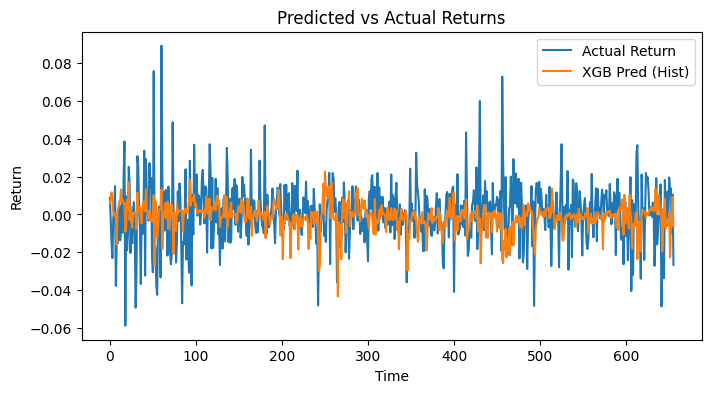

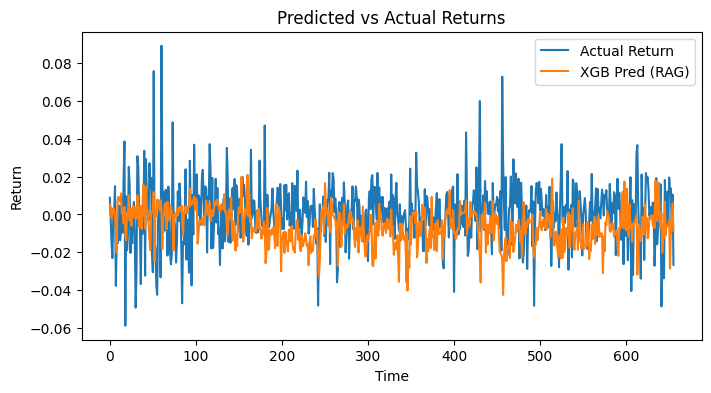

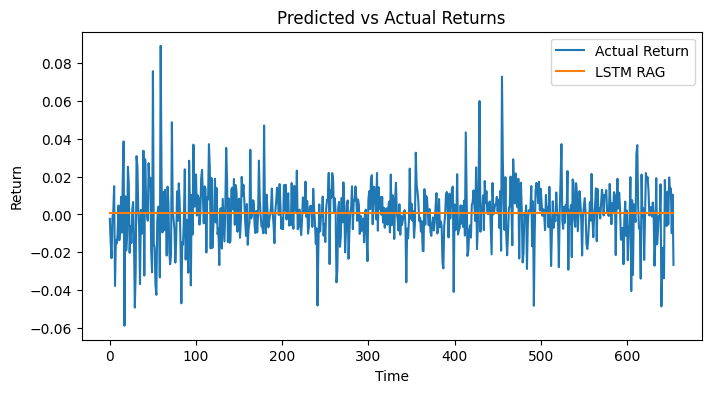

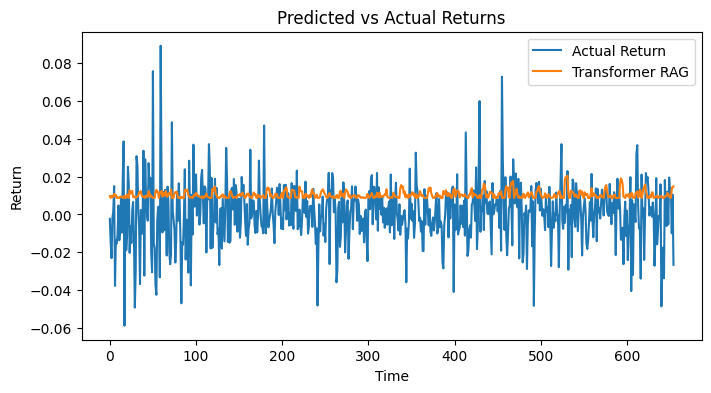

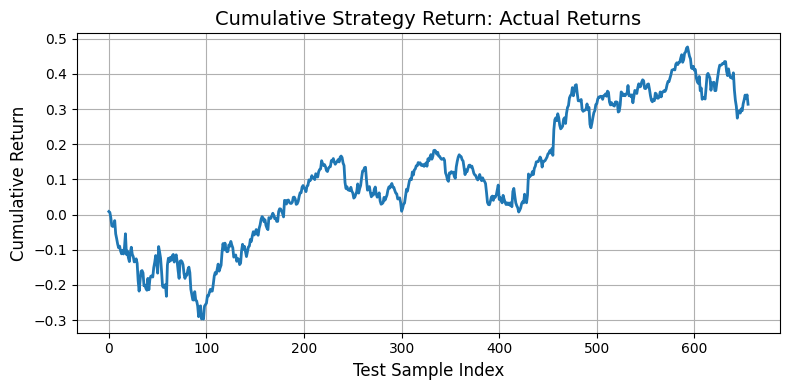

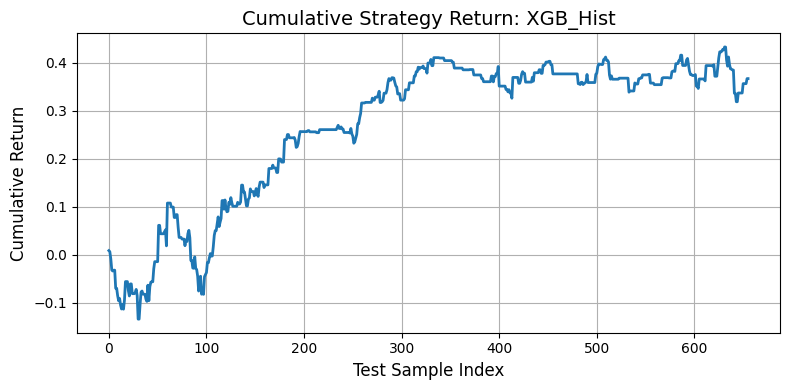

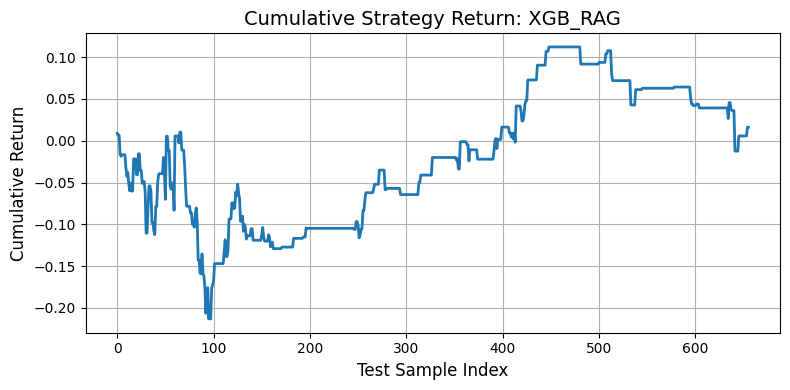

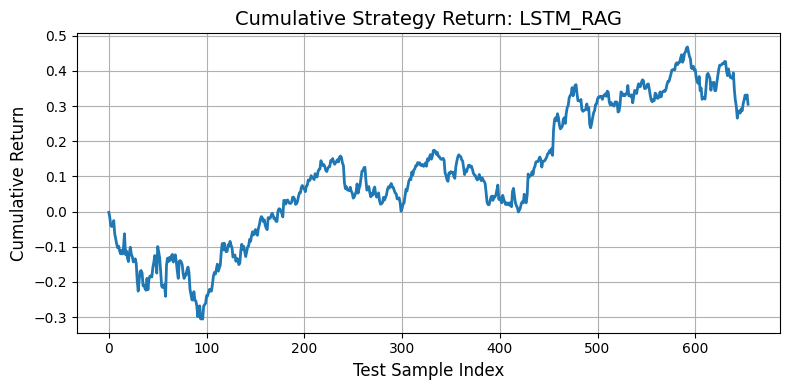

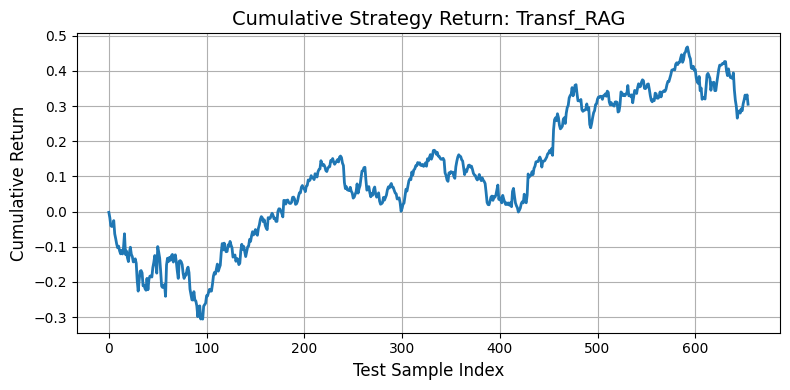

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_test.values, label='Actual Return')
plt.plot(y_pred_hist, label='XGB Pred (Hist)')
plt.legend(); plt.title("Predicted vs Actual Returns"); plt.xlabel("Time"); plt.ylabel("Return")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(y_test.values, label='Actual Return')
plt.plot(y_pred_rag, label='XGB Pred (RAG)')
plt.legend(); plt.title("Predicted vs Actual Returns"); plt.xlabel("Time"); plt.ylabel("Return")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(true_test, label='Actual Return')
plt.plot(pred_test, label='LSTM RAG')
plt.legend(); plt.title("Predicted vs Actual Returns"); plt.xlabel("Time"); plt.ylabel("Return")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(true_test_tf, label='Actual Return')
plt.plot(pred_test_tf, label='Transformer RAG')
plt.legend(); plt.title("Predicted vs Actual Returns"); plt.xlabel("Time"); plt.ylabel("Return")
plt.show()

strat_returns = {
    'Actual Returns': y_test.values,
    'XGB_Hist':   y_test.values * (y_pred_hist   > 0),
    'XGB_RAG':    y_test.values * (y_pred_rag    > 0),
    'LSTM_RAG':   true_test    * (pred_test     > 0),
    'Transf_RAG': true_test_tf * (pred_test_tf  > 0),
}

# 2. Plot each cumulative return separately
for name, ret in strat_returns.items():
    cumret = np.cumsum(ret)
    plt.figure(figsize=(8,4))
    plt.plot(cumret, linewidth=2)
    plt.title(f'Cumulative Strategy Return: {name}', fontsize=14)
    plt.xlabel('Test Sample Index', fontsize=12)
    plt.ylabel('Cumulative Return', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [53]:
import pandas as pd
# (Assuming the CSVs are in the working directory)
df_stock = pd.read_csv('../../dataset/results0/AAPL_yahoo_data_0.csv', parse_dates=['Date'])
df_news  = pd.read_csv('../../dataset/3years_results/AAPL_alpha_news_data.csv', parse_dates=['published_date'])
df_stock.set_index('Date', inplace=True)
print(df_stock.columns)  # e.g. Index(['Open','High','Low','Close','Adj Close','Volume'],...)


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'Daily Return', 'MA20', 'MA50', 'Volatility',
       'Market Cap', 'Dividend Yield'],
      dtype='object')


In [54]:
data = df_stock.copy()
data['return'] = data['Adj Close'].pct_change()
data['ma_5']    = data['Adj Close'].rolling(5).mean()
data['ma_10']   = data['Adj Close'].rolling(10).mean()
data['vol_5']   = data['return'].rolling(5).std()
data['vol_10']  = data['return'].rolling(10).std()
data.dropna(inplace=True)
